In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch.optim as optim
import torch.nn.functional as F
import time
import json

In [6]:
def result_graph():
    plt.figure(1)
    plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'train loss')
    plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss Curve')
    plt.legend()

def confmat(data_loader):
    
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_idx , (inpust,target) in enumerate(data_loader):
            inputs,target = inpust.cuda(),target.cuda()
            output = model(inputs)
            loss = criterion(output,target)  
            running_loss += loss.data.item()

        loss = running_loss/len(data_loader.dataset)
        print('{} MSE_Loss: {:.4f} '.format('test', loss))



def fit(epoch,model,data_loader,phase='train',volatile=False):
    model.train()
    running_loss = 0.0

    if phase == 'valid':
        with torch.no_grad():
            for batch_idx , (inputs,target) in enumerate(data_loader):
                inputs,target = inputs.cuda(),target.cuda()
                outputs = model(inputs)
                loss = criterion(outputs,target)  
                running_loss += loss.data.item()
            loss = running_loss/len(data_loader.dataset)
            print('{} Loss: {:.4f} '.format(phase, loss))
            
    if phase == 'train':
        with torch.set_grad_enabled(phase == 'train'):
            for batch_idx , (inpust,target) in enumerate(data_loader):
                inputs,target = inpust.cuda(),target.cuda()
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output,target)  
                running_loss += loss.data.item()
                loss.backward()
                optimizer.step()
        loss = running_loss/len(data_loader.dataset)
        print('{} Loss: {:.4f} '.format(phase, loss))

    
   
    return loss

In [3]:
class customdatset(object):
    
    def __init__(self, path, img_transforms):
        self.path = path
        self.transforms = img_transforms
        with open(self.path+'/jsonfile.json') as json_file:
            self.json_data = json.load(json_file)

    def __getitem__(self, idx):
        img_path =  self.json_data[idx]['file_name']
        self.img = Image.open(img_path).convert("RGB")
        self.img = self.transforms(self.img)

        self.target = np.array(self.json_data[idx]['depth'], dtype = np.float32)
        self.target = torch.from_numpy(self.target)
        self.target = self.target.view(-1)
        return self.img, self.target

    def __len__(self):
        return len(self.json_data)


Epoch 1/5
----------
train Loss: 0.1736 
valid Loss: 0.2759 

Epoch 2/5
----------
train Loss: 0.1606 
valid Loss: 0.2625 

Epoch 3/5
----------
train Loss: 0.1486 
valid Loss: 0.2863 

Epoch 4/5
----------
train Loss: 0.1392 
valid Loss: 0.2355 

Epoch 5/5
----------
train Loss: 0.1290 
valid Loss: 0.2280 
Training complete in 1m 48s


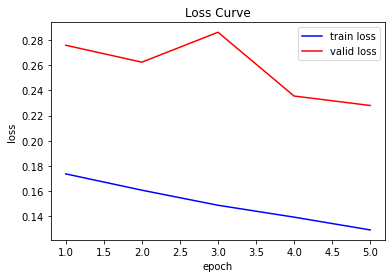

In [4]:
batch_size = 16
num_epochs = 5
transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

model = models.resnet50(pretrained=True)
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, 1)
    
model.dropout = nn.Dropout(p=0.5)

if torch.cuda.is_available():
    model = model.cuda()
    
criterion = torch.nn.MSELoss() 
optimizer = optim.Adam(model.parameters(),lr=0.000001)

train_json_path = r'C:\Users\yonsei\Desktop\regression\dataset\1\Train\label'
validation_json_path = r'C:\Users\yonsei\Desktop\regression\dataset\1\Test\label'

traindataset = customdatset(train_json_path,transform)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size = batch_size, shuffle=True, num_workers=0, pin_memory=True)

validdataset = customdatset(validation_json_path,transform)
validloader = torch.utils.data.DataLoader(validdataset, batch_size = batch_size, shuffle=True, num_workers=0, pin_memory=True)

since = time.time()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    #fit에서 학습시 한 에폭의 결과값을 받음
    epoch_loss = fit(epoch,model,trainloader,phase='train')
    val_epoch_loss = fit(epoch,model,validloader,phase='valid')
    
    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    
result_graph()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
time_elapsed // 60, time_elapsed % 60))
    

In [7]:
test_json_path  =  r'C:\Users\yonsei\Desktop\regression\dataset\1\Test\label'
testdataset = customdatset(train_json_path,transform)
testloader = torch.utils.data.DataLoader(testdataset, batch_size = batch_size, shuffle=True, num_workers=0, pin_memory=True)
confmat(testloader)

test MSE_Loss: 0.1211 
